In [7]:
import os, sys, json
from pprint import pprint

import scipy
import numpy as np

from stats import instance_changed_prediction, efficacy_reduction_per_instance_scaled, changed_prediction, compute_specificity, average_efficacy, make_stats
from util import list_learning_rates, unique_instances, load_results, sort_key, group_results, filter_for_agreement, load_best_full_lrs
from const import datasets, models, model_name_dict, model_name_to_path, dataset_model_best_lr, LETTERS
from plotting import scatter_results, probs_barplot

In [8]:
model_to_nice_model = {
    'Phi-3': 'Phi-3',
    'LLaMA-3': 'LLaMA-3-8B',
    'LLaMA-3-3B': 'LLaMA-3-3B',
    'Mistral-2': 'Mistral-2',
}

dataset_to_nice_dataset = {
    'arc-challenge': 'ARC-Challenge',
    'openbook': 'OpenBookQA',
    'sqa': 'StrategyQA',
    'sports': 'Sports'
}

## Load results from logfile

In [9]:
extracted_lrs = list_learning_rates("ablation")

In [10]:
pprint(extracted_lrs)

{'arc-challenge_LLaMA-3': [1e-06, 3e-06, 5e-06, 1e-05, 3e-05, 5e-05],
 'arc-challenge_LLaMA-3-3B': [5e-06, 1e-05, 3e-05, 0.0001],
 'arc-challenge_Mistral-2': [1e-06, 3e-06, 5e-06, 1e-05, 3e-05],
 'arc-challenge_Phi-3': [5e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.0005, 0.001],
 'openbook_LLaMA-3': [1e-06, 3e-06, 5e-06, 1e-05, 3e-05],
 'openbook_LLaMA-3-3B': [1e-05, 3e-05, 5e-05, 0.0001],
 'openbook_Mistral-2': [1e-06, 3e-06, 5e-06, 1e-05, 3e-05],
 'openbook_Phi-3': [1e-05, 3e-05, 5e-05, 0.0001, 0.0003, 0.0005, 0.001],
 'sports_LLaMA-3': [1e-06, 3e-06, 5e-06, 1e-05, 5e-05],
 'sports_LLaMA-3-3B': [5e-06, 1e-05, 3e-05, 5e-05, 0.0001],
 'sports_Mistral-2': [3e-06, 5e-06, 1e-05],
 'sports_Phi-3': [3e-05, 5e-05, 0.0001, 0.0005],
 'sqa_LLaMA-3': [3e-06, 5e-06, 1e-05, 3e-05, 5e-05, 0.0001],
 'sqa_LLaMA-3-3B': [5e-06, 1e-05, 3e-05, 5e-05, 0.0001],
 'sqa_Mistral-2': [3e-06, 5e-06, 1e-05],
 'sqa_Phi-3': [3e-05, 5e-05, 0.0001, 0.0005]}


## Compute some stats over all instances

In [11]:
def traverse_stats(path_root, type="full", method='npo_KL', rs=1001, ff2=False, pos=False, sample=False, do_print=False):
    results = {}
    for dataset in datasets:
        for model in models:
            extracted_model_lrs = extracted_lrs[f"{dataset}_{model}"]
            for lr in sorted(extracted_model_lrs):
                floc = f'{path_root}/{dataset}/{model}/{method}_{type}_s=True_lr={lr}_rs={rs}_pos={pos}_ff2={ff2}.out'
                if not os.path.exists(floc):
                    continue
        
                per_instance_results = load_results(floc, sample=sample)
                
                if per_instance_results:
                    
                    if dataset not in results:
                        results[dataset] = {}
                    if model not in results[dataset]:
                        results[dataset][model] = {}
                    if method not in results[dataset][model]:
                        results[dataset][model][method] = {}
                    if lr not in results[dataset][model][method]:
                        results[dataset][model][method][lr] = {}
                    
                    results[dataset][model][method][lr] = make_stats(per_instance_results)
    return results

In [12]:
lr_ablation = traverse_stats("ablation", "sentencize", pos=True, ff2=True, do_print=True)

In [13]:
def tabular_lr_selection(full_results):
    result_criteria = {}
    model_lrs = {}
    for dataset, dataset_results in sorted(full_results.items(), key=lambda t:t[0]):
        for model, model_results in sorted(dataset_results.items(), key = lambda t:t[0]):
            print(dataset, model, list(model_results['npo_KL'].keys()))
            model_results = model_results['npo_KL']
            key = f"{dataset}_{model}"
            result_criteria[key] = {}
            for lr, lr_results in sorted(model_results.items(), key = lambda t:t[0]):
                lr_key = f"{key}_{lr}"
                # pprint(lr_results)
                E = lr_results['efficacy']
                S = lr_results['specificity']
                F = lr_results['faithfulness']
                crit = scipy.stats.hmean([E, S])
                result_criteria[lr_key] = (E,S,F, crit)
                if model not in model_lrs: model_lrs[model] = set()
                model_lrs[model].add(lr)
                if round(S) >= 95 or (dataset == 'sports' and model == 'Mistral-2' and S >= 93):
                    # Threshold at 95% specificity or take the best performing?
                    print(f"lr = {lr} -> {S:.3f}, {E:.3f}, {F:.3f}")
                    crit = scipy.stats.hmean([E, F])
    return result_criteria, model_lrs

In [14]:
e_s_results, m_d_lr = tabular_lr_selection(lr_ablation)

arc-challenge LLaMA-3 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05, 5e-05]
lr = 1e-06 -> 99.167, 0.336, 6.667
lr = 3e-06 -> 99.111, 2.912, 13.333
lr = 5e-06 -> 98.880, 12.233, 20.000
lr = 1e-05 -> 97.611, 33.192, 46.667
arc-challenge LLaMA-3-3B [5e-06, 1e-05, 3e-05, 0.0001]
lr = 5e-06 -> 97.031, 1.335, 10.000
lr = 1e-05 -> 97.729, 5.697, 30.000
lr = 3e-05 -> 97.396, 27.572, 76.667
arc-challenge Mistral-2 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05]
lr = 1e-06 -> 99.976, 11.169, 10.000
lr = 3e-06 -> 98.976, 42.888, 30.000
lr = 5e-06 -> 95.622, 58.992, 46.667
arc-challenge Phi-3 [5e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.0005, 0.001]
lr = 5e-06 -> 100.000, 0.371, 0.000
lr = 1e-05 -> 100.000, 1.289, 3.333
lr = 3e-05 -> 100.000, 5.244, 6.667
lr = 0.0001 -> 99.424, 34.162, 53.333
openbook LLaMA-3 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05]
lr = 1e-06 -> 97.429, 0.448, 3.333
lr = 3e-06 -> 97.543, 3.698, 3.333
lr = 5e-06 -> 97.543, 13.694, 16.667
lr = 1e-05 -> 97.219, 34.101, 43.333
openbook LLaMA-3-3B [1e-05, 3e-05, 5e-0

In [15]:
print(m_d_lr)

{'LLaMA-3': {1e-05, 5e-05, 0.0001, 5e-06, 3e-06, 3e-05, 1e-06}, 'LLaMA-3-3B': {1e-05, 5e-05, 5e-06, 0.0001, 3e-05}, 'Mistral-2': {1e-05, 5e-06, 3e-06, 3e-05, 1e-06}, 'Phi-3': {1e-05, 0.0003, 5e-05, 5e-06, 0.0001, 3e-05, 0.001, 0.0005}}


In [16]:
from const import datasets, models

DATASETS = sorted(list(datasets))
MODELS = sorted(list(models))

In [17]:
for dataset in datasets:
    print(dataset, end = " & ")
print()
for model in MODELS:
    print(model, end=" & ")
    for lr in sorted(m_d_lr[f"{model}"]):
        print(f"${lr}$", end=" & ")
        for dataset in DATASETS:
            lr_key = f"{dataset}_{model}_{lr}"
            ending = " & " if dataset != DATASETS[-1] else " \\\\"
            if lr_key not in e_s_results:
                print(" $-$ & $-$ & $-$", end=ending)
                continue

            e, s, f, crit = e_s_results[lr_key]

            print(f"${e:.1f}$ & ${s:.1f}$ & ${f:.1f}$", end=ending) #  & ${crit:.2f}$
        print()
    print()

arc-challenge & openbook & sports & sqa & 
LLaMA-3 & $1e-06$ & $0.3$ & $99.2$ & $6.7$ & $0.4$ & $97.4$ & $3.3$ & $0.6$ & $98.5$ & $10.0$ &  $-$ & $-$ & $-$ \\
$3e-06$ & $2.9$ & $99.1$ & $13.3$ & $3.7$ & $97.5$ & $3.3$ & $5.5$ & $98.7$ & $13.3$ & $4.2$ & $99.2$ & $6.7$ \\
$5e-06$ & $12.2$ & $98.9$ & $20.0$ & $13.7$ & $97.5$ & $16.7$ & $18.9$ & $98.1$ & $26.7$ & $31.4$ & $93.9$ & $33.3$ \\
$1e-05$ & $33.2$ & $97.6$ & $46.7$ & $34.1$ & $97.2$ & $43.3$ & $41.8$ & $94.0$ & $43.3$ & $36.2$ & $94.8$ & $33.3$ \\
$3e-05$ & $62.5$ & $91.2$ & $60.0$ & $64.0$ & $87.6$ & $73.3$ &  $-$ & $-$ & $-$ & $65.8$ & $78.9$ & $86.7$ \\
$5e-05$ & $73.2$ & $81.2$ & $70.0$ &  $-$ & $-$ & $-$ & $75.7$ & $57.8$ & $80.0$ & $74.6$ & $67.4$ & $90.0$ \\
$0.0001$ &  $-$ & $-$ & $-$ &  $-$ & $-$ & $-$ &  $-$ & $-$ & $-$ & $79.6$ & $59.5$ & $96.7$ \\

LLaMA-3-3B & $5e-06$ & $1.3$ & $97.0$ & $10.0$ &  $-$ & $-$ & $-$ & $1.4$ & $100.0$ & $3.3$ & $1.9$ & $100.0$ & $13.3$ \\
$1e-05$ & $5.7$ & $97.7$ & $30.0$ & $7.1$ & $99.3

In [18]:
def select_best_lr(full_results):
    result_criteria = {}
    correlates = {}
    for dataset, dataset_results in sorted(full_results.items(), key=lambda t:t[0]):
        for model, model_results in sorted(dataset_results.items(), key = lambda t:t[0]):
            print(dataset, model, list(model_results['npo_KL'].keys()))
            model_results = model_results['npo_KL']
            key = f"{dataset}_{model}"
            result_criteria[key] = {}
            for lr, lr_results in sorted(model_results.items(), key = lambda t:t[0]):
                lr_key = f"{key}_{lr}"
                # pprint(lr_results)
                E = lr_results['efficacy']
                S = lr_results['specificity']
                F = lr_results['faithfulness']
                correlates[lr_key] = (E,F)
                
                if round(S) >= 95 or (dataset == 'sports' and model == 'Mistral-2' and S >= 93): # Threshold at 95% specificity or take the best performing?
                    print(f"lr = {lr} -> {S:.3f}, {E:.3f}, {F:.3f}")
                    crit = E
                    result_criteria[key][lr] = crit
    return result_criteria, correlates

In [19]:
selection, correlates = select_best_lr(lr_ablation)

arc-challenge LLaMA-3 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05, 5e-05]
lr = 1e-06 -> 99.167, 0.336, 6.667
lr = 3e-06 -> 99.111, 2.912, 13.333
lr = 5e-06 -> 98.880, 12.233, 20.000
lr = 1e-05 -> 97.611, 33.192, 46.667
arc-challenge LLaMA-3-3B [5e-06, 1e-05, 3e-05, 0.0001]
lr = 5e-06 -> 97.031, 1.335, 10.000
lr = 1e-05 -> 97.729, 5.697, 30.000
lr = 3e-05 -> 97.396, 27.572, 76.667
arc-challenge Mistral-2 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05]
lr = 1e-06 -> 99.976, 11.169, 10.000
lr = 3e-06 -> 98.976, 42.888, 30.000
lr = 5e-06 -> 95.622, 58.992, 46.667
arc-challenge Phi-3 [5e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.0005, 0.001]
lr = 5e-06 -> 100.000, 0.371, 0.000
lr = 1e-05 -> 100.000, 1.289, 3.333
lr = 3e-05 -> 100.000, 5.244, 6.667
lr = 0.0001 -> 99.424, 34.162, 53.333
openbook LLaMA-3 [1e-06, 3e-06, 5e-06, 1e-05, 3e-05]
lr = 1e-06 -> 97.429, 0.448, 3.333
lr = 3e-06 -> 97.543, 3.698, 3.333
lr = 5e-06 -> 97.543, 13.694, 16.667
lr = 1e-05 -> 97.219, 34.101, 43.333
openbook LLaMA-3-3B [1e-05, 3e-05, 5e-0

In [20]:
best_model_dataset_lr = {}
for k, candidates in selection.items():
    best_lr, hm = sorted(candidates.items(), key = lambda t:-t[1])[0]
    best_model_dataset_lr[k] = best_lr
    print(k, best_lr, hm)
    print("-"*30)

arc-challenge_LLaMA-3 1e-05 33.19180728316567
------------------------------
arc-challenge_LLaMA-3-3B 3e-05 27.57233778095483
------------------------------
arc-challenge_Mistral-2 5e-06 58.99170917784305
------------------------------
arc-challenge_Phi-3 0.0001 34.16164752092481
------------------------------
openbook_LLaMA-3 1e-05 34.10096355898341
------------------------------
openbook_LLaMA-3-3B 3e-05 31.533178968640026
------------------------------
openbook_Mistral-2 5e-06 57.04951966810047
------------------------------
openbook_Phi-3 0.0001 38.13673558879538
------------------------------
sports_LLaMA-3 5e-06 18.881582493860545
------------------------------
sports_LLaMA-3-3B 3e-05 25.547196707311823
------------------------------
sports_Mistral-2 3e-06 41.371530415084976
------------------------------
sports_Phi-3 5e-05 33.00373556237262
------------------------------
sqa_LLaMA-3 1e-05 36.200641345492585
------------------------------
sqa_LLaMA-3-3B 3e-05 30.97886100996962
--

## LR Selection plots

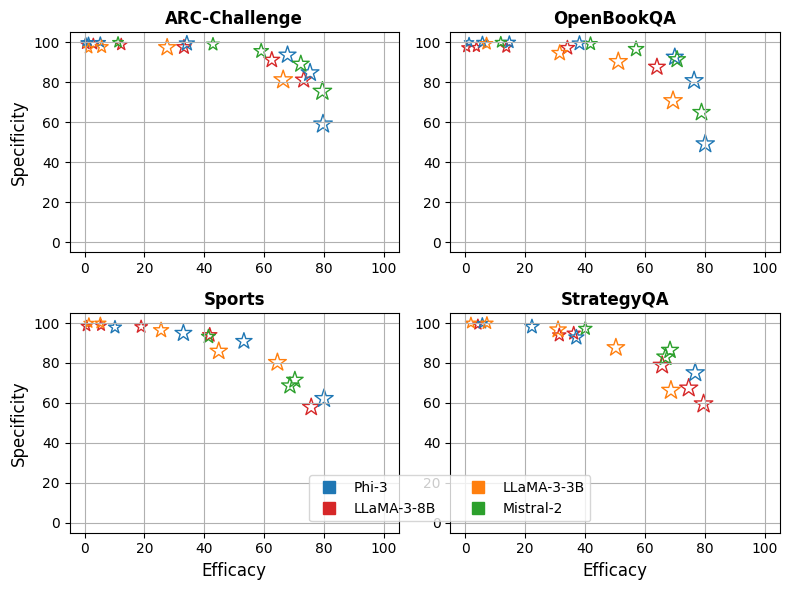

In [21]:
scatter_results(lr_ablation, savefig=True, fmt='pdf')

## Write out the full results with the best learning rates for tables & plots

In [22]:
best_results = load_best_full_lrs('results', 'sentencize')

In [23]:
filtered_best_results = {}
for a_key, result in sorted(best_results.items(), key=lambda t: sort_key(t[0])):
    dataset, model, _, _ = a_key.split(",")
    filtered_result = filter_for_agreement(result)
    filtered_best_results[a_key] = filtered_result

grouped_best_results = group_results(filtered_best_results)

In [24]:
faithfulness_stats = {}

for a_key, results in grouped_best_results.items(): # grouped_results or grouped_correct_results
    d, m, _, _ = a_key.split(",")
    k_s = ' '.join([d,m])
    faithfulness = []
    for idx, (q_key, q_results) in enumerate(results.items()):
        ff = False # So far, instance-level
        for unlearned_step in q_results:
            step_results = unlearned_step['unlearning_results']
            has_flip, flips = instance_changed_prediction(step_results)
            if has_flip:
                ff=True
                break
        faithfulness.append(ff)
    ff_mu = np.mean(faithfulness)
    N = len(faithfulness)
    if k_s in faithfulness_stats:
        if ff_mu > faithfulness_stats[k_s][0]:
            faithfulness_stats[k_s] = (ff_mu, N) 
    else:
        faithfulness_stats[k_s] = (ff_mu, N)

In [25]:
def compute_step_faithfulness(some_results):
    step_faithfulness_stats = {}
    
    for a_key, results in some_results.items():
        d, m, _, _ = a_key.split(",")
        k_s = ' '.join([d,m])
        faithfulness = []
        for idx, (q_key, q_results) in enumerate(results.items()):
            ff = False # So far, instance-level
            for unlearned_step in q_results:
                step_results = unlearned_step['unlearning_results']
                has_flip, flips = instance_changed_prediction(step_results)
                faithfulness.append(has_flip)
    
        ff_mu = np.mean(faithfulness)
        N = len(faithfulness)
        if k_s in step_faithfulness_stats:
            if ff_mu > step_faithfulness_stats[k_s][0]:
                step_faithfulness_stats[k_s] = (ff_mu, N) 
        else:
            step_faithfulness_stats[k_s] = (ff_mu, N)
    return step_faithfulness_stats

In [26]:
step_faithfulness_stats = compute_step_faithfulness(grouped_best_results)

In [27]:
print('\t\t' + '\t'.join(['arc-challenge', 'openbook', 'sports', '\tsqa']))
for model in ['LLaMA-3', 'LLaMA-3-3B', 'Mistral-2', 'Phi-3']:
    print(f"{model:10s}:", end= " => ")
    for dataset in ['arc-challenge', 'openbook', 'sports', 'sqa']:
        k = ' '.join([dataset, model])
        #n = step_faithfulness_stats[k][1]
        n = faithfulness_stats[k][1]
        # View print
        # print(f"{faithfulness_stats[k][0]*100.:.2f}%, n= {n}", end="\t")
        # Latex print
        print(f"${faithfulness_stats[k][0]*100.:.2f}$\%", end=" & ")

        # Step faithfulness, view print
        # print(f"{step_faithfulness_stats[k][0]*100.:.2f}%, n= {n}", end="\t")
        # Latex print
        # print(f"${step_faithfulness_stats[k][0]*100.:.2f}$\%", end=" & ")
    print()

		arc-challenge	openbook	sports		sqa
LLaMA-3   : => $39.58$\% & $44.33$\% & $29.31$\% & $30.65$\% & 
LLaMA-3-3B: => $64.41$\% & $68.60$\% & $64.88$\% & $71.02$\% & 
Mistral-2 : => $39.47$\% & $60.00$\% & $45.26$\% & $48.19$\% & 
Phi-3     : => $39.05$\% & $46.15$\% & $53.99$\% & $22.22$\% & 


## Plot correlation between efficacy and specificity

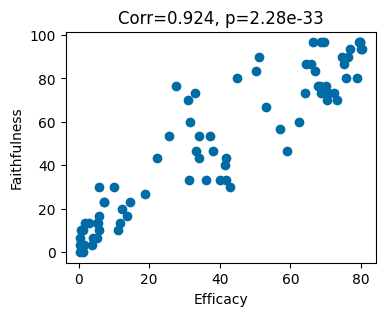

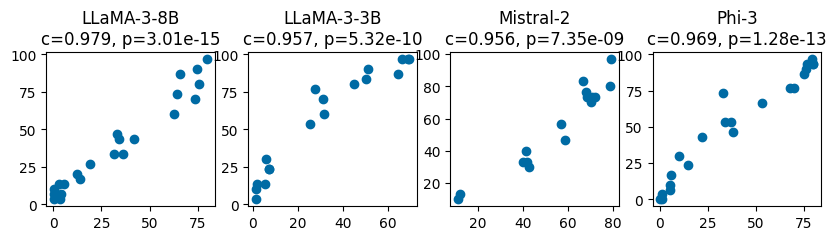

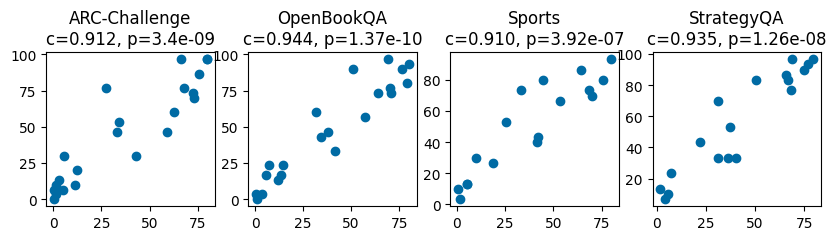

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

plt.style.use('tableau-colorblind10')

def correlation_plot(frame, title_prefix=""):
    plt.figure(figsize=(4, 3))
    corr = pearsonr(frame['efficacy'], frame['faithfulness'])
    
    plt.scatter(frame['efficacy'], frame['faithfulness'])
    if title_prefix:
        title_prefix += ": "

    plt.title(f"{title_prefix}Corr={corr.statistic:.3f}, p={corr.pvalue:.3g}")
    plt.xlabel('Efficacy')
    plt.ylabel('Faithfulness')
    plt.savefig('figures/correlation_overall.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def correlation_subplots(a_dict, type=''):
    N = len(a_dict)
    fig, (axs) = plt.subplots(1, N, figsize=(10,2))

    for idx, (k, vals) in enumerate(a_dict.items()):
        E, F = list(zip(*vals))
        frame = pd.DataFrame({
            'efficacy': E,
            'faithfulness': F,
        })
        corr = pearsonr(frame['efficacy'], frame['faithfulness'])
        axs[idx].scatter(frame['efficacy'], frame['faithfulness'])

        if k in dataset_to_nice_dataset:
            name = dataset_to_nice_dataset[k]
        elif k in model_to_nice_model:
            name = model_to_nice_model[k]
        axs[idx].set_title(f"{name}\nc={corr.statistic:.3f}, p={corr.pvalue:.3g}")
    plt.savefig(f'figures/{type}_correlates.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Overall correlation
E, F = list(zip(*correlates.values()))
frame = pd.DataFrame({
    'efficacy': E,
    'faithfulness': F,
})

correlation_plot(frame)

per_dataset_corr = {}
per_model_corr = {}
for k, v in correlates.items():
    d, m, _ = k.split("_")
    if m not in per_model_corr:
        per_model_corr[m] = []

    if d not in per_dataset_corr:
        per_dataset_corr[d] = []

    per_model_corr[m].append(v)
    per_dataset_corr[d].append(v)

correlation_subplots(per_model_corr, type='model')
correlation_subplots(per_dataset_corr, type='dataset')

## Stats before unlearning

In [29]:
grouped_results = group_results(best_results)

In [30]:
nocot_stats = {}
cot_stats = {}

for a_key, results in grouped_results.items(): # grouped_results
    nocot_stats[a_key] = []
    cot_stats[a_key] = []
    for idx, (q_key, q_results) in enumerate(results.items()):
        y_hat = LETTERS.index(q_results[0]['correct'])
        correct_nocot = q_results[0]['prediction'] == y_hat
        correct_cot = q_results[0]['cot_prediction'] == y_hat

        nocot_stats[a_key].append(correct_nocot)
        cot_stats[a_key].append(correct_cot)

In [31]:
model_stats = {}
for k in sorted(nocot_stats):
    d, m, _, _ = k.split(",")
    k_s = ' '.join([d,m])
    if k_s in model_stats:
        continue
    model_stats[k_s] = {
        'nocot': np.mean(nocot_stats[k]),
        'cot': np.mean(cot_stats[k]),
    }

In [32]:
# nocot then cot format for latex table
for model in ['LLaMA-3', 'LLaMA-3-3B', 'Mistral-2', 'Phi-3']:
    for dataset in ['arc-challenge', 'openbook', 'sports', 'sqa']:
        k = ' '.join([dataset, model])
        e = " \\\\" if dataset == 'sqa' else " & "
        print(f"${model_stats[k]['nocot']:.3f}$", end=e)
    print()
    for dataset in ['arc-challenge', 'openbook', 'sports', 'sqa']:
        k = ' '.join([dataset, model])
        e = " \\\\" if dataset == 'sqa' else " & "
        print(f"${model_stats[k]['cot']:.3f}$", end=e)
    print()

$0.817$ & $0.704$ & $0.702$ & $0.670$ \\
$0.839$ & $0.778$ & $0.763$ & $0.730$ \\
$0.726$ & $0.674$ & $0.500$ & $0.609$ \\
$0.774$ & $0.757$ & $0.561$ & $0.652$ \\
$0.709$ & $0.739$ & $0.711$ & $0.622$ \\
$0.774$ & $0.730$ & $0.719$ & $0.696$ \\
$0.909$ & $0.804$ & $0.610$ & $0.622$ \\
$0.870$ & $0.848$ & $0.789$ & $0.713$ \\
